In [22]:
import torch
import matplotlib.pyplot as plt


In [23]:
# Setup
size = 5
states = size * size
actions = 4
num_rewards = 2
gamma = 0.9
goal = states - 1

possible_rewards = torch.tensor([0.0, 1.0])

# Joint distribution: p(s', r | s, a)
transition_probabilities = torch.zeros(states, actions, states, num_rewards)
v = torch.zeros(states)
policy = torch.ones(states, actions) / actions


In [24]:
for s in range(states):
    row, col = s // size, s % size

    moves = [
        (max(0, row - 1), col),
        (min(size - 1, row + 1), col),
        (row, max(0, col - 1)),
        (row, min(size - 1, col + 1))
    ]

    for a, (new_row, new_col) in enumerate(moves):
        s_prime = new_row * size + new_col

        if s_prime == goal:
            transition_probabilities[s, a, s_prime, 1] = 1.0
        else:
            transition_probabilities[s, a, s_prime, 0] = 1.0



In [25]:
def action_value(s, a):
  q_ = 0.0
  for s_prime in range(states):
    for r_idx in range(num_rewards):
        prob_ = transition_probabilities[s, a, s_prime, r_idx]
        reward_ = possible_rewards[r_idx]
        value_function_ = v[s_prime]
        q_ += prob_ * (reward_ + gamma *value_function_ )
  return q_

def state_value(s):
    v_ = 0.0
    action_values = torch.zeros(actions)
    for a in range(actions):
        policy_prob = policy[s, a]
        action_v = action_value(s, a)
        action_values[a] = action_v
        v_ += policy_prob * action_v
    return v_

# Policy Iteration

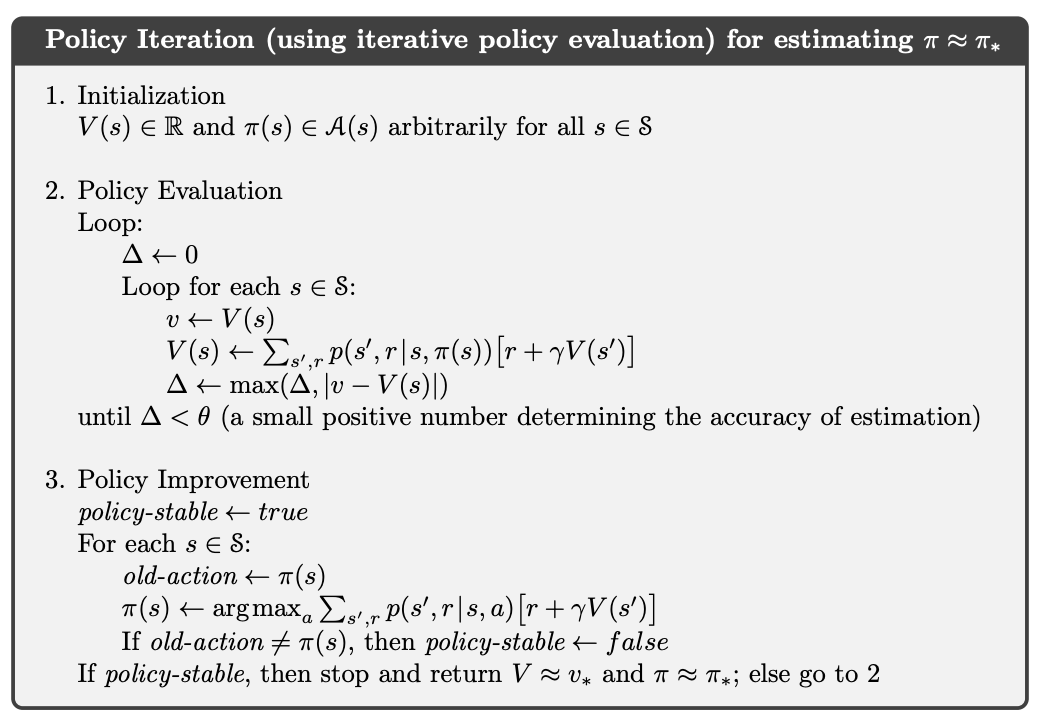

In [26]:
theta = 0.00001
v = torch.zeros(states)
q = torch.zeros(states, actions)
policy = torch.ones(states, actions) / actions


In [27]:

def policy_evaluation(v, q, theta=0.01):
    while True:
        delta = 0.0
        for s in range(states):
            v_old = v[s]
            v[s] = state_value(s)

            for a in range(actions):
                q[s, a] = action_value(s, a)

            delta = max(delta, abs(v_old - v[s]))
        if delta < theta:
            break
    return v, q


def policy_improvement(policy, v, q):
    for s in range(states):
        q_ = torch.zeros(actions)
        for a in range(actions):
            q_[a] = action_value(s, a)

        best_a = torch.argmax(q_)
        policy[s] = torch.zeros(actions)
        policy[s, best_a] = 1

    return policy

In [30]:
v,q = policy_evaluation(v,q) # full sweep on states
policy = policy_improvement(policy, v,q ) # improve
v,q = policy_evaluation(v,q) # full sweep on states
policy = policy_improvement(policy, v,q )# improve
v,q = policy_evaluation(v,q) # full sweep on states


# iteratively
while True:
    v, q = policy_evaluation(v, q) # full sweep on states
    old_policy = policy.clone()
    policy = policy_improvement(policy, v, q)  # improve
    if torch.equal(old_policy, policy):
        break



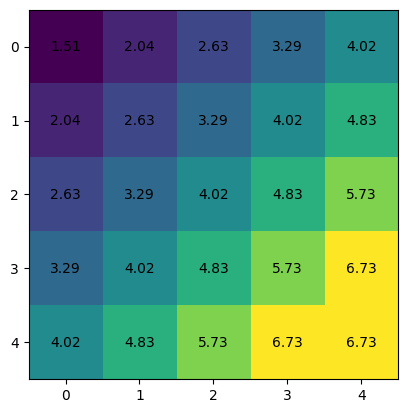

In [31]:

plt.imshow(v.view(5,5))
for i in range(5):
    for j in range(5):
        plt.text(j, i, f"{v[i*5+j]:.2f}", ha="center", va="center", color="black")

# Value Iteration

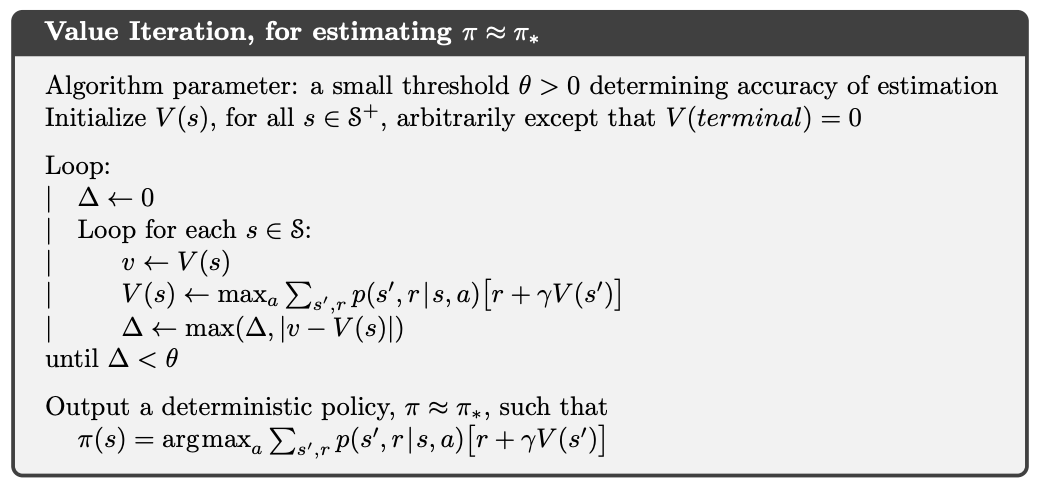

In [32]:
policy = torch.ones(states, actions) / actions
v = torch.zeros(states)
q = torch.zeros(states, actions)
theta = 0.1

In [33]:
def policy_evaluation(v, q, theta=0.01):
  while True:
      delta = 0.0
      for s in range(states):
          v_old = v[s]
          q_values = [action_value(s,a) for a in range(actions)]
          v[s] = max(q_values)
          q[s] = torch.tensor(q_values)
          delta = max(delta, abs(v_old - v[s]))

      if delta < theta:
          break
  return v, q


In [34]:
# we don't need any policy improvement step

while True:
    v_old = v.clone()
    v, q = policy_evaluation(v, q, theta=0.01)

    if torch.max(torch.abs(v - v_old)) < theta:
        break

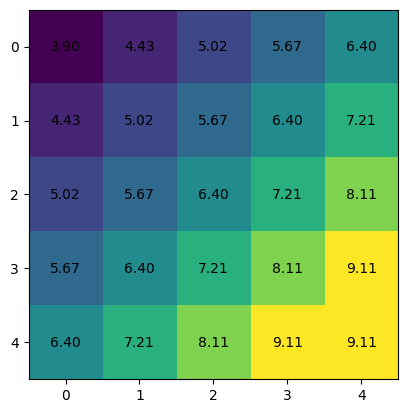

In [35]:
plt.imshow(v.view(5,5))
for i in range(5):
    for j in range(5):
        plt.text(j, i, f"{v[i*5+j]:.2f}", ha="center", va="center", color="black")
